Áp dụng early stopping và tăng regularization để ổn định Val Loss.

In [1]:
# Cell 1: Import tất cả các thư viện cần thiết
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [2]:
# Cell 3: Định nghĩa lớp Dataset (tái sử dụng từ dataset_dataloader.ipynb)
class M5MultiDataset(Dataset):
    def __init__(self, data, feature_cols, window_size):
        self.data = data
        self.cols = feature_cols
        self.win = window_size

    def __len__(self):
        return len(self.data) - self.win

    def __getitem__(self, idx):
        slice_ = self.data.iloc[idx:idx+self.win]
        X_num = slice_[self.cols].values.astype('float32')  # (win, num_features)
        item_idx = slice_['item_idx'].values.astype('int64')  # (win,)
        store_idx = slice_['store_idx'].values.astype('int64')  # (win,)
        y = self.data['sales'].iloc[idx+self.win].astype('float32')
        return (
            torch.tensor(X_num),  # (win, num_features)
            torch.tensor(item_idx),  # (win,)
            torch.tensor(store_idx)  # (win,)
        ), torch.tensor(y)

In [3]:
# Cell 4: Định nghĩa lớp mô hình LSTMEmbForecast
class LSTMEmbForecast(nn.Module):
    def __init__(self, n_items, n_stores, embed_dim, num_feats, hidden_size):
        super().__init__()
        self.item_emb = nn.Embedding(n_items, embed_dim)
        self.store_emb = nn.Embedding(n_stores, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_feats + 2*embed_dim,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3  # Tăng dropout từ 0.2 lên 0.3
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, X_num, X_item, X_store):
        batch_size, seq_len, _ = X_num.size()
        emb_i = self.item_emb(X_item)  # (B, T, E)
        emb_s = self.store_emb(X_store)  # (B, T, E)
        x = torch.cat([X_num, emb_i, emb_s], dim=-1)  # (B, T, F+2E)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Lấy output cuối cùng: (B, hidden_size)
        return self.fc(out).squeeze()

In [4]:
# Cell 5: Đọc thông tin từ model_params.txt và tái tạo DataLoader
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset

# Đọc thông tin từ model_params.txt
with open('model_params.txt', 'r') as f:
    lines = f.readlines()
    num_items = int(lines[0].split(': ')[1])
    num_stores = int(lines[1].split(': ')[1])
    feature_cols = eval(lines[2].split(': ')[1])

# Xác định kiểu dữ liệu nhẹ hơn để giảm tải RAM
dtypes = {
    'sales': 'float32',
    'sell_price': 'float32',
    'sales_lag_7': 'float32',
    'sales_lag_14': 'float32',
    'sales_lag_28': 'float32',
    'rolling_mean_7': 'float32',
    'item_idx': 'int32',
    'store_idx': 'int32',
    'day': 'int8',
    'month': 'int8',
    'weekday': 'int8',
    'week': 'int8',
    'snap_CA': 'int8',
    'snap_TX': 'int8',
    'snap_WI': 'int8'
}
# Đọc một hàng để lấy danh sách cột evt_
for col in pd.read_csv('processed_data.csv', nrows=1).columns:
    if col.startswith('evt_'):
        dtypes[col] = 'int8'

# Chỉ lấy các cột cần thiết để giảm kích thước dữ liệu
use_cols = ['item_id', 'store_id', 'sales', 'sell_price', 'date'] + \
           [col for col in pd.read_csv('processed_data.csv', nrows=1).columns 
            if col.startswith('evt_') or col in ['snap_CA', 'snap_TX', 'snap_WI']] + \
           ['sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'rolling_mean_7', 'item_idx', 'store_idx']

# Đọc dữ liệu theo chunks để giảm tải RAM
chunk_size = 10000  # Đọc 100,000 hàng mỗi lần
chunks = pd.read_csv('processed_data.csv', chunksize=chunk_size, dtype=dtypes, usecols=use_cols)

# Gộp các chunks thành DataFrame
df_chunks = []
for chunk in chunks:
    df_chunks.append(chunk)
df = pd.concat(df_chunks, ignore_index=True)

# Chia dữ liệu thành train và validation
split = int(len(df) * 0.8)
df_train, df_val = df.iloc[:split], df.iloc[split:]

# Tối ưu bộ nhớ bằng cách giải phóng df sau khi tạo df_train và df_val
df = None  # Giải phóng bộ nhớ

# Tạo Dataset và DataLoader
window_size = 14  # Giảm window_size từ 28 xuống 14 để giảm tải RAM
batch_size = 32   # Giảm batch_size từ 64 xuống 32 để giảm tải RAM

train_ds = M5MultiDataset(df_train, feature_cols, window_size=window_size)
val_ds = M5MultiDataset(df_val, feature_cols, window_size=window_size)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ sau khi tạo DataLoader
df_train, df_val = None, None  # Giải phóng bộ nhớ

print('Recreated train_loader and val_loader with optimized memory usage')

Recreated train_loader and val_loader with optimized memory usage


In [5]:
# Cell 6: Khởi tạo mô hình, hàm mất mát, và optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMEmbForecast(
    n_items=num_items,
    n_stores=num_stores,
    embed_dim=16,
    num_feats=len(feature_cols),
    hidden_size=128
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Thêm L2 regularization
scaler = GradScaler()


In [6]:
# Cell 7: Hàm huấn luyện mô hình với early stopping
def train_model(model, train_loader, val_loader, num_epochs, device):
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    best_model_path = 'best_model.pth'

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for (X_num, X_item, X_store), y in train_loader:
            Xn, Xi, Xs, y = X_num.to(device), X_item.to(device), X_store.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast(device_type='cuda'):  # Sử dụng cú pháp rõ ràng cho PyTorch 2.6.0
                preds = model(Xn, Xi, Xs)
                loss = criterion(preds, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        
        # Đánh giá trên tập validation
        model.eval()
        val_loss = 0
        predictions, actuals = [], []
        with torch.no_grad():
            for (Xn, Xi, Xs), y in val_loader:
                Xn, Xi, Xs, y = Xn.to(device), Xi.to(device), Xs.to(device), y.to(device)
                with autocast(device_type='cuda'):
                    preds = model(Xn, Xi, Xs)
                    loss = criterion(preds, y)
                val_loss += loss.item()
                predictions.extend(preds.cpu().numpy())
                actuals.extend(y.cpu().numpy())
        
        # Tính RMSE và MAE
        val_loss = val_loss / len(val_loader)
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {total_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Loss: {best_val_loss:.4f}")
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Tải mô hình tốt nhất
    model.load_state_dict(torch.load(best_model_path))
    return model

In [7]:
# Cell 8: Huấn luyện mô hình
model = train_model(model, train_loader, val_loader, num_epochs=20, device=device)

KeyboardInterrupt: 

In [ ]:
# Cell 9: Lưu mô hình đã huấn luyện
torch.save(model.state_dict(), 'lstm_forecast2.pth')
print("Final model saved to 'lstm_forecast2.pth'")
print("Best model saved to 'best_model.pth'")

Final model saved to 'lstm_forecast2.pth'
Best model saved to 'best_model.pth'


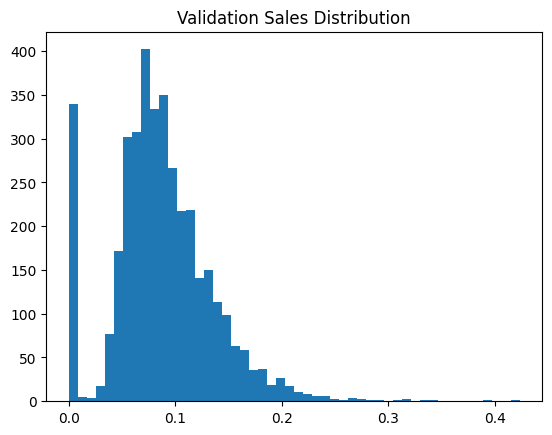

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df_val['sales'], bins=50)
plt.title('Validation Sales Distribution')
plt.show()